In [2]:
import pandas as pd

df = pd.read_csv('resfe_df_delivery_mode_2024-02-23.csv')
data_cleaned = df.copy(deep=True)

In [9]:
data_cleaned.drop(columns='elective_emergency',inplace=True)

In [ ]:
data_cleaned

In [5]:
! pip install transformers
# ! pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 37.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 4.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 33.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 2.6 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.7.1
    Uninstalling fsspec-2022.7.1:
      Successfully uninstalled fsspec-2022.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.

[notice] A new release of pip is available: 

In [6]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import torch

In [7]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    return text

# Function to generate grid for RF
def get_random_grid():
    """
    Generate a dictionary with parameters names (`str`) as keys and distributions
    or lists of parameters to try.
    """
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]
    # Number of features to consider at every split
    max_features = ['log2', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 11, num=7)]
    max_depth.append(None)  # Also consider the scenario of not limiting the depth
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }
    return random_grid


# Function to create BERT embeddings
def create_bert_embeddings(model, tokenizer, texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].squeeze().detach().cpu().numpy()
    return embeddings

# Function to perform randomized search and return the best model
def perform_random_search(X, y):
    # Hyperparameter space
    random_grid = get_random_grid()
    # Random search
    rf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X, y)
    return rf_random.best_estimator_

# Function to plot ROC curves
def plot_roc_curves(models, test_features, y_test, model_names):
    plt.figure(figsize=(10, 8))
    for i, (model, name) in enumerate(zip(models, model_names)):
        # Predict probabilities
        y_pred_proba = model.predict_proba(test_features[i])[:, 1]
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Plot
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing emilyalsentzer/Bio_ClinicalBERT...
generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


generating pca components
generating train/test
running model
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing bert-base-uncased...
generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


generating pca components
generating train/test
running model
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing dmis-lab/biobert-v1.1...
generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


generating pca components
generating train/test
running model
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12...
generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


generating pca components
generating train/test
running model
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Processing microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext...
generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


generating pca components
generating train/test
running model
Fitting 3 folds for each of 10 candidates, totalling 30 fits


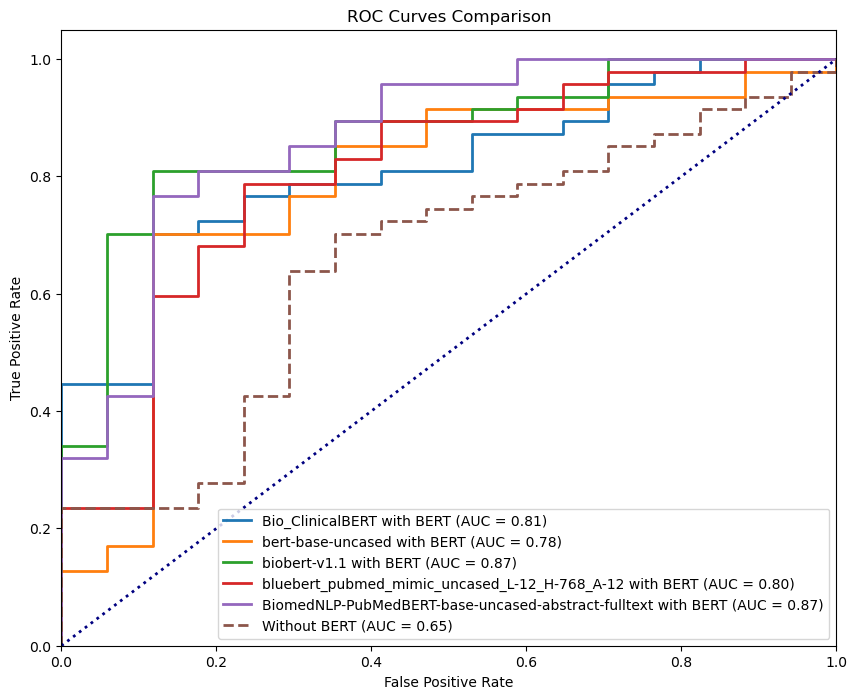

In [19]:
# Preprocess the text data and split the dataset
data_cleaned['preprocessed_text'] = data_cleaned['diagnosis'].apply(preprocess_text)
X = data_cleaned.drop(columns=['delivery_mode_NVD', 'diagnosis'])
y = data_cleaned['delivery_mode_NVD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract and preprocess numerical features
numerical_features = X_train.drop(columns=['preprocessed_text', 'patient_id'])  # Adjust as necessary
numerical_features_test = X_test.drop(columns=['preprocessed_text', 'patient_id'])  # Adjust as necessary

# Define BERT models to compare
bert_models = [
    "emilyalsentzer/Bio_ClinicalBERT",
    "bert-base-uncased",
    "dmis-lab/biobert-v1.1",
    "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12",
    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
]

# Initialize storage for models and features
best_models_with_bert = []
best_models_without_bert = []
test_features_with_bert = []

# Train and evaluate model without BERT embeddings (only numerical features)
best_model_without_bert = perform_random_search(numerical_features.values, y_train)

# Create test features without BERT embeddings only once
test_features_without_bert = numerical_features_test.values

for bert_model in bert_models:
    print(f"Processing {bert_model}...")
    tokenizer = AutoTokenizer.from_pretrained(bert_model)
    model = AutoModel.from_pretrained(bert_model)

    # Generate BERT embeddings
    print('generating embeddings')
    train_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_train['preprocessed_text'], 10)])
    test_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_test['preprocessed_text'], 10)])

    # Optional: Dimensionality reduction
    print('generating pca components')
    pca = PCA(n_components=0.75, svd_solver='full')
    train_embeddings_reduced = pca.fit_transform(train_embeddings)
    test_embeddings_reduced = pca.transform(test_embeddings)

    print('generating train/test')
    # Combine embeddings with numerical features for the "with BERT" model
    train_combined_with_bert = np.hstack([train_embeddings_reduced, numerical_features.values])
    test_combined_with_bert = np.hstack([test_embeddings_reduced, numerical_features_test.values])

    print('running model')
    # Train and evaluate models with BERT embeddings
    best_model_with_bert = perform_random_search(train_combined_with_bert, y_train)
    best_models_with_bert.append(best_model_with_bert)
    test_features_with_bert.append(test_combined_with_bert)

# Function to plot ROC curves, modified to handle both model types
def plot_comparison_roc_curves(models_with_bert, model_without_bert, test_features_with_bert, test_features_without_bert, y_test, model_names):
    plt.figure(figsize=(10, 8))

    for i, name in enumerate(model_names):
        # With BERT
        y_pred_proba_with_bert = models_with_bert[i].predict_proba(test_features_with_bert[i])[:, 1]
        fpr_with_bert, tpr_with_bert, _ = roc_curve(y_test, y_pred_proba_with_bert)
        roc_auc_with_bert = roc_auc_score(y_test, y_pred_proba_with_bert)

        # Plot only if there are BERT models
        if models_with_bert:
            plt.plot(fpr_with_bert, tpr_with_bert, label=f'{name} with BERT (AUC = {roc_auc_with_bert:.2f})', lw=2)
        else:
            plt.plot(fpr_with_bert, tpr_with_bert, label=f'{name} (AUC = {roc_auc_with_bert:.2f})', lw=2)

    # Without BERT
    if model_without_bert is not None:
        y_pred_proba_without_bert = model_without_bert.predict_proba(test_features_without_bert)[:, 1]
        fpr_without_bert, tpr_without_bert, _ = roc_curve(y_test, y_pred_proba_without_bert)
        roc_auc_without_bert = roc_auc_score(y_test, y_pred_proba_without_bert)
        plt.plot(fpr_without_bert, tpr_without_bert, label=f'Without BERT (AUC = {roc_auc_without_bert:.2f})', lw=2, linestyle='--')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle=':')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.show()


# Simplify model names for the legend
model_names = [model.split("/")[-1] for model in bert_models]

# Plot ROC curves comparison
plot_comparison_roc_curves(best_models_with_bert, best_model_without_bert, test_features_with_bert, test_features_without_bert, y_test, model_names)


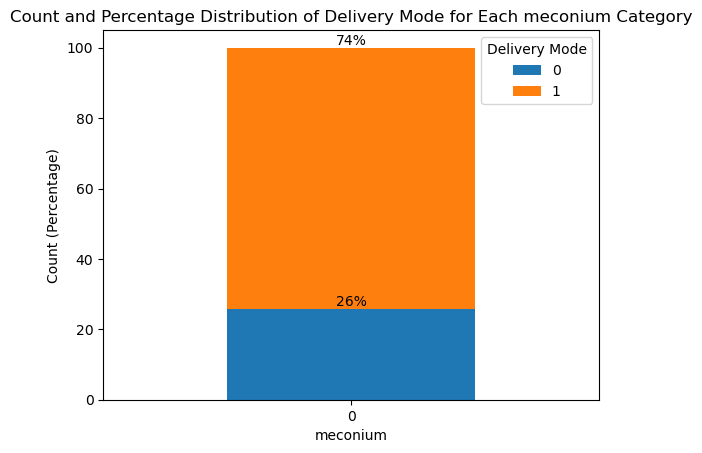

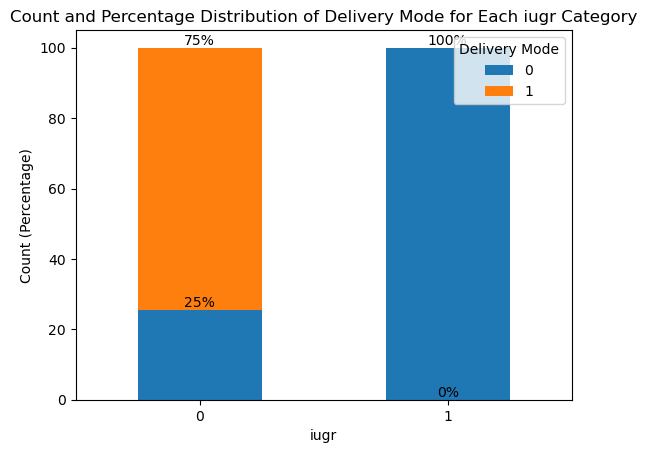

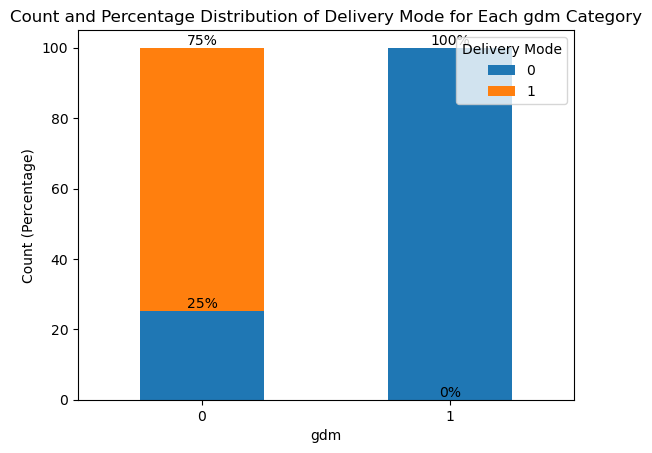

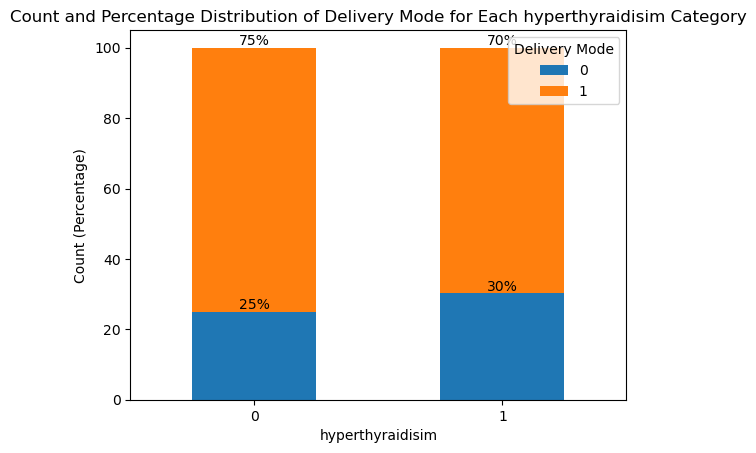

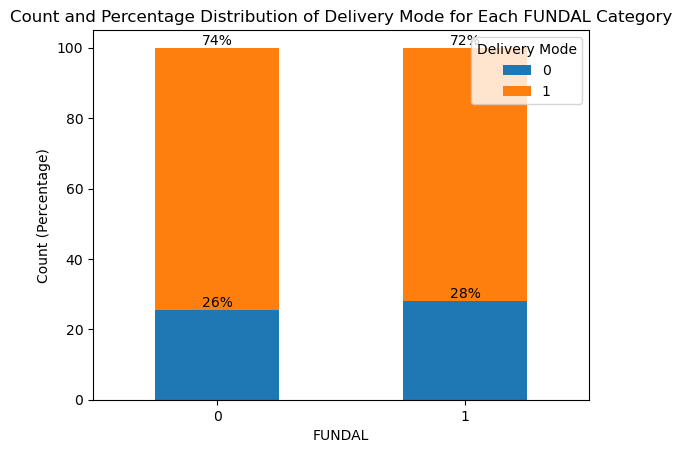

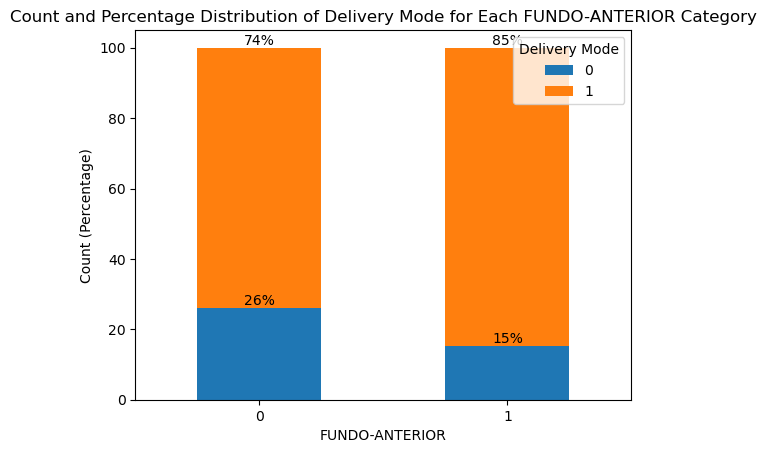

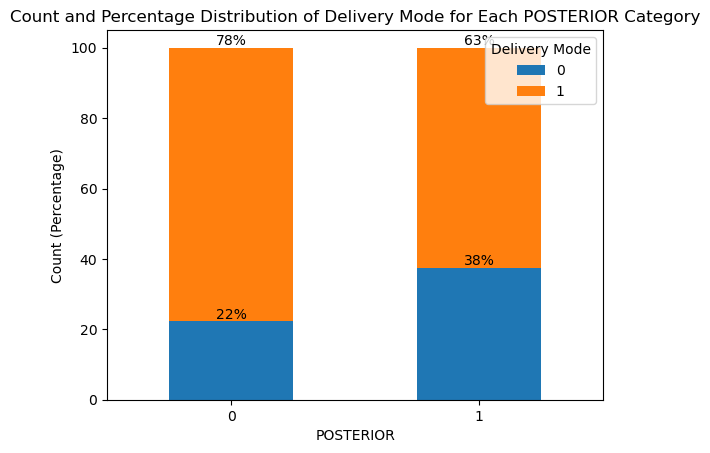

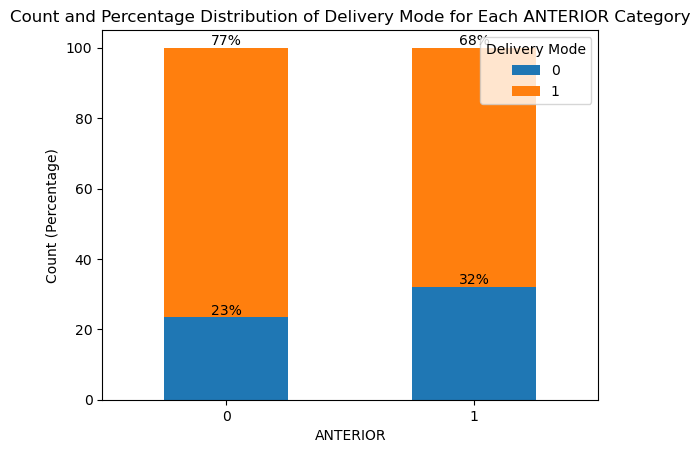

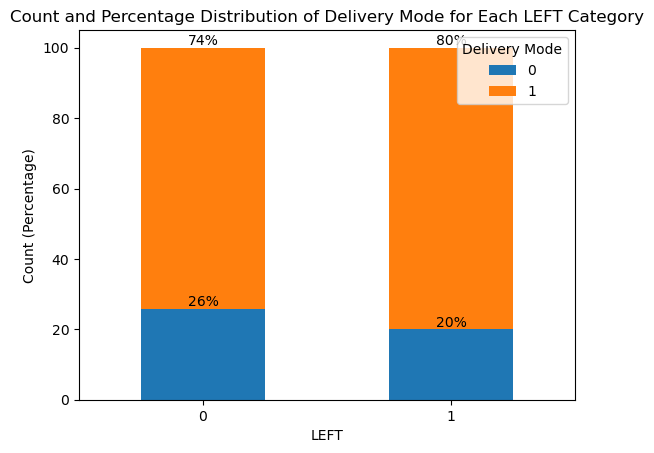

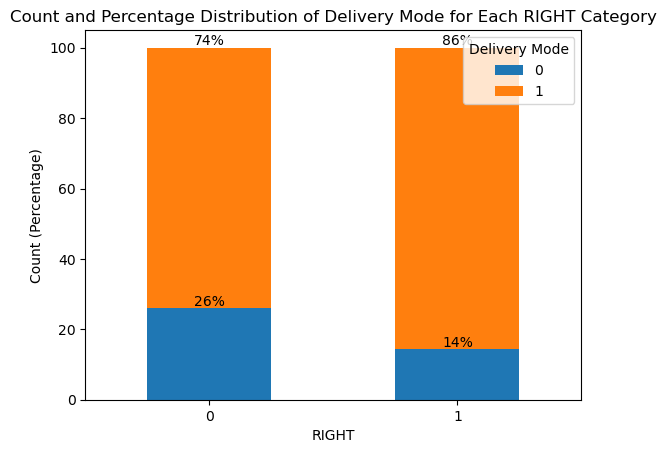

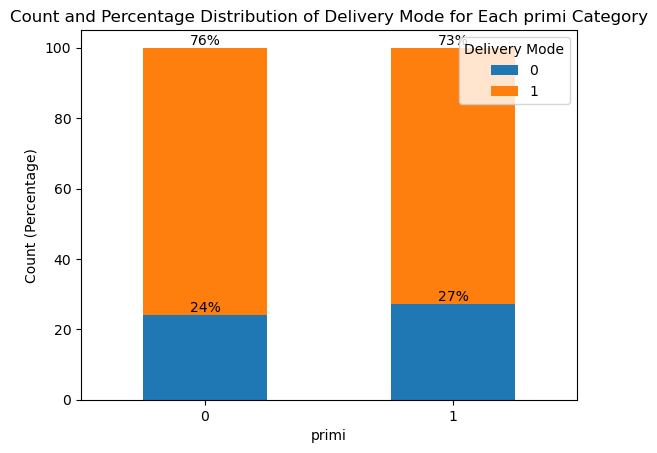

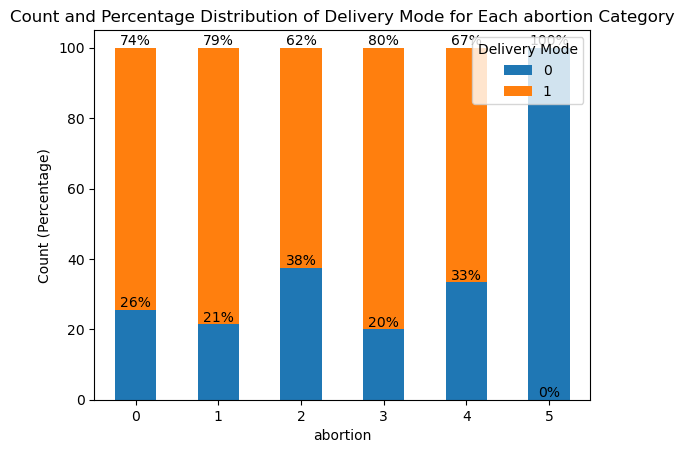

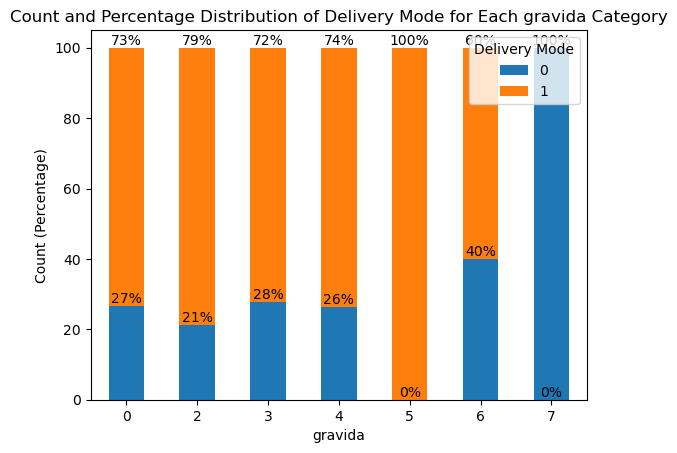

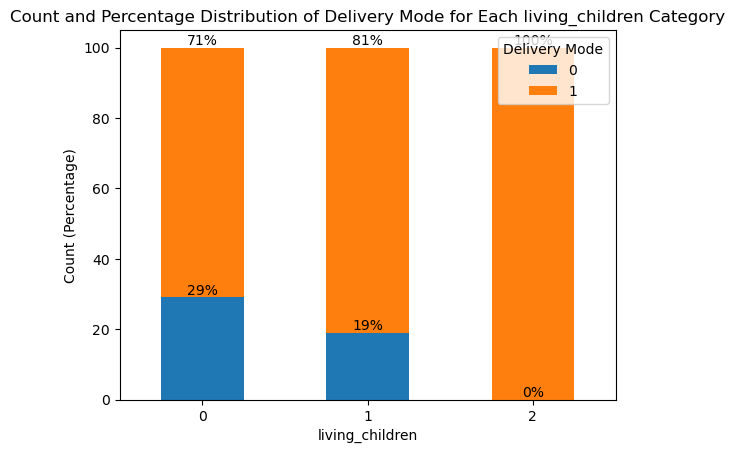

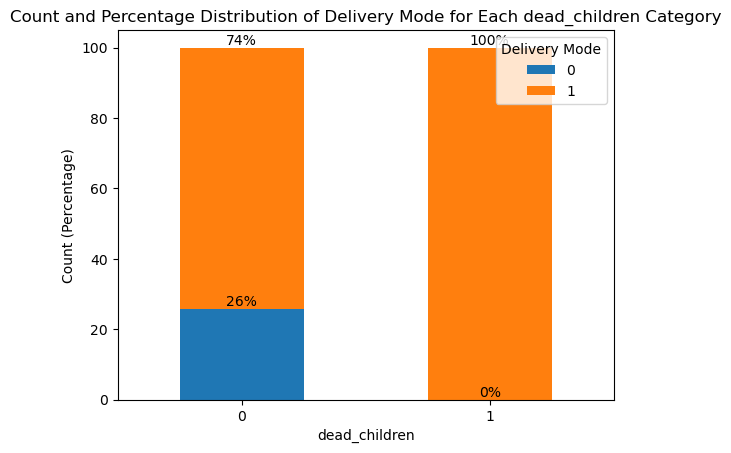

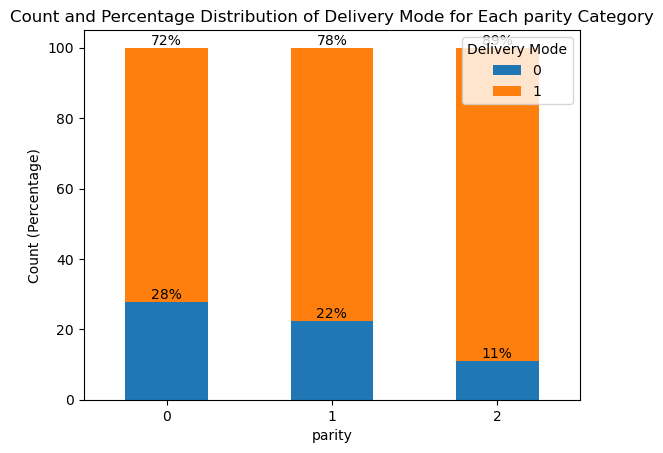

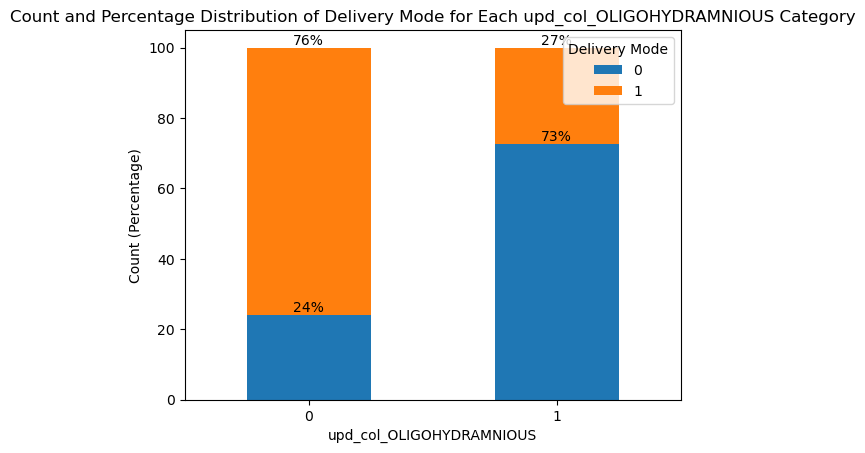

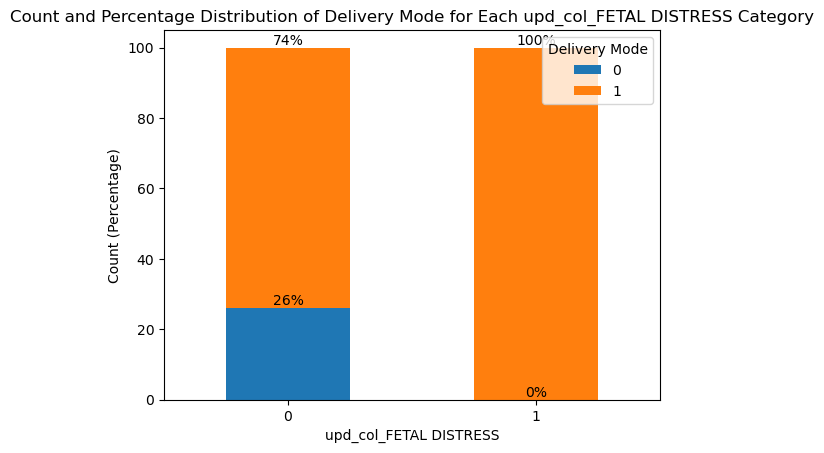

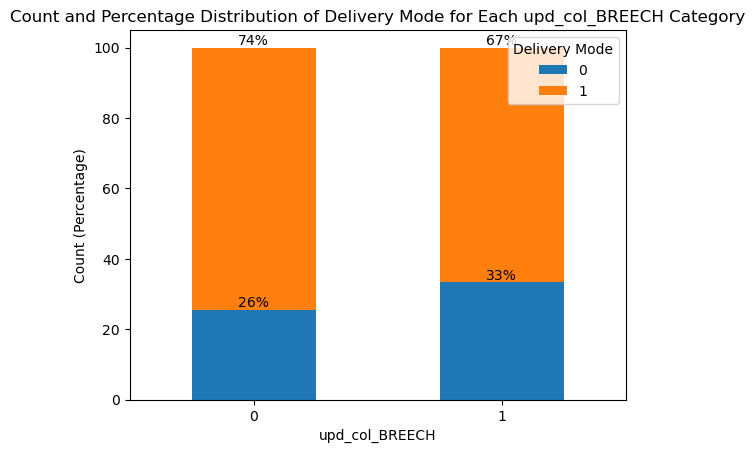

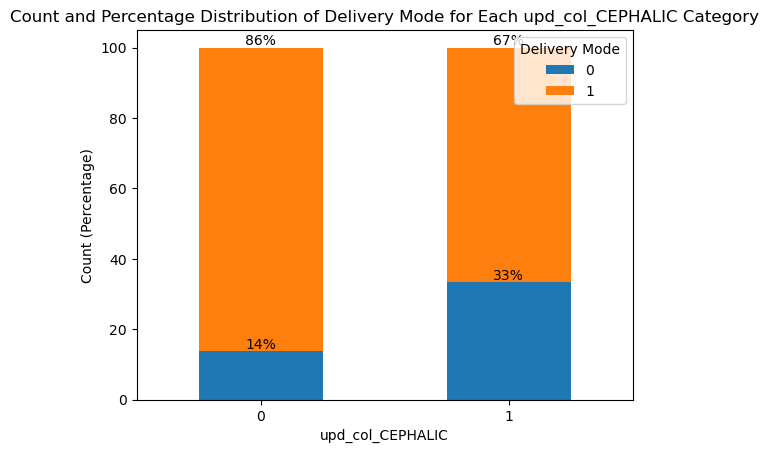

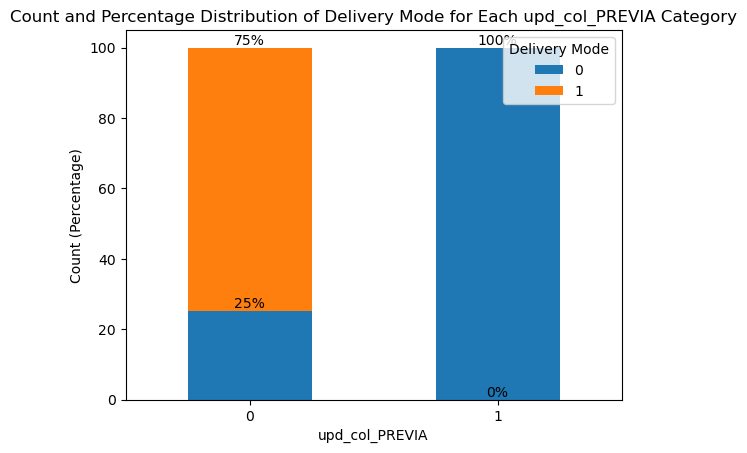

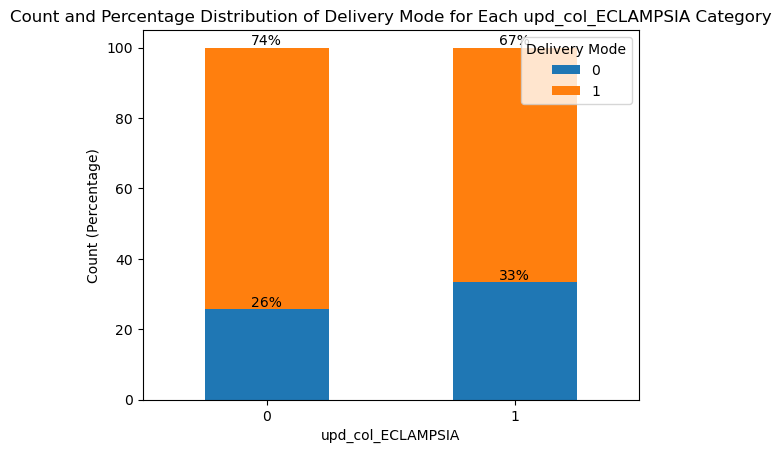

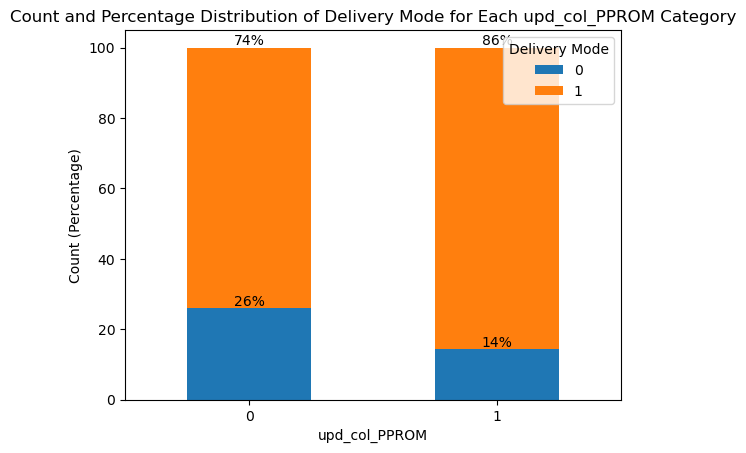

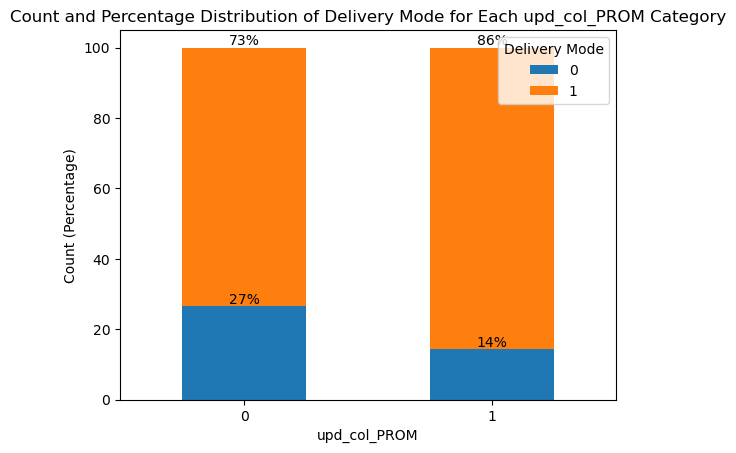

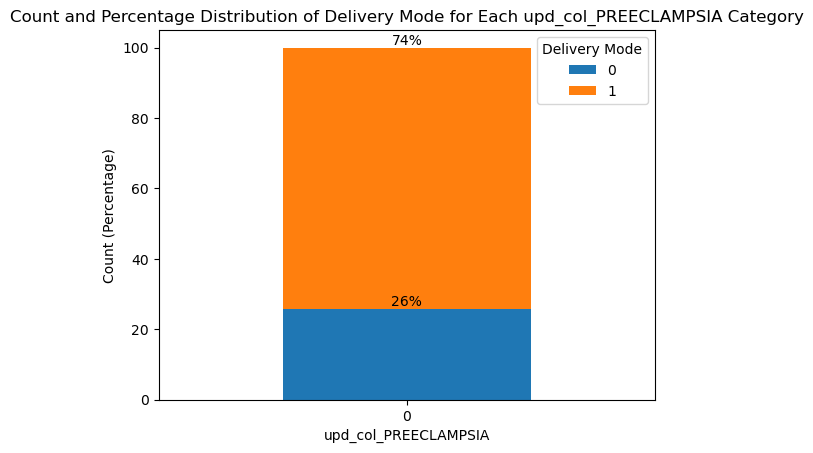

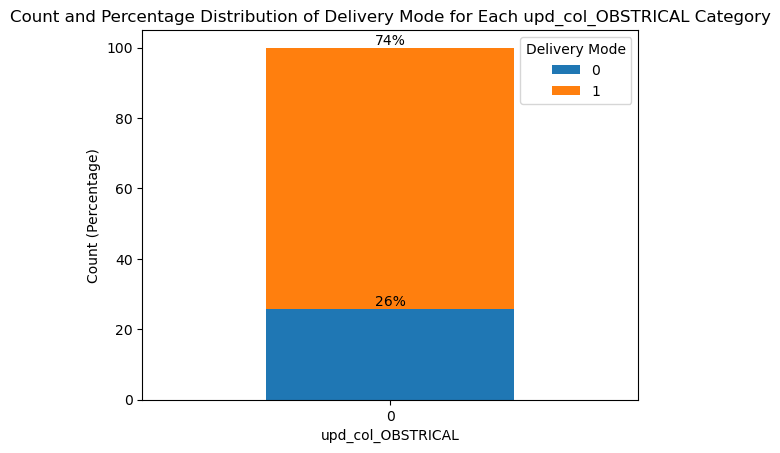

In [21]:
cols=  [ 'meconium', 'iugr', 'gdm', 'hyperthyraidisim', 'FUNDAL', 'FUNDO-ANTERIOR', 'POSTERIOR',
         'ANTERIOR', 'LEFT', 'RIGHT', 'primi', 'abortion', 'gravida',
         'living_children', 'dead_children', 'parity',
         'upd_col_OLIGOHYDRAMNIOUS', 'upd_col_FETAL DISTRESS', 'upd_col_BREECH',
         'upd_col_CEPHALIC', 'upd_col_PREVIA', 'upd_col_ECLAMPSIA',
         'upd_col_PPROM', 'upd_col_PROM', 'upd_col_PREECLAMPSIA',
         'upd_col_OBSTRICAL']

# Iterate over each column
for col in cols:
    # Calculate count and percentage distribution
    count_distribution = df.groupby([col, 'delivery_mode_NVD'])['patient_id'].count()
    percentage_distribution = count_distribution / df.groupby(col)['patient_id'].count() * 100
    percentage_distribution = percentage_distribution.unstack()

    # Plot
    ax = percentage_distribution.plot(kind='bar', stacked=True)

    # Add count and percentage labels on the bars
    for container in ax.containers:
        ax.bar_label(container, labels=[f'{h:.0f}%' for h in container.datavalues], label_type='edge')

    ax.set_xlabel(col)
    ax.set_ylabel('Count (Percentage)')
    ax.set_title(f'Count and Percentage Distribution of Delivery Mode for Each {col} Category')
    ax.legend(title='Delivery Mode', loc='upper right')
    ax.set_xticklabels(percentage_distribution.index, rotation=0)

    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


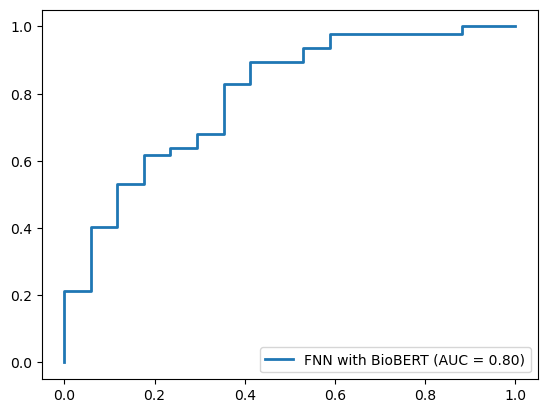

[CV] END bootstrap=False, max_depth=11, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, max_depth=11, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=False, max_depth=11, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END bootstrap=False, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END bootstrap=False, max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time=   0.8s
[CV] END bootstrap=False, max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=6, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=9, max_fea

In [23]:
from sklearn.neural_network import MLPClassifier

# Train and evaluate FNN model with BioBERT embeddings
def train_and_evaluate_fnn(X_train, y_train, X_test, y_test):
    # Initialize FNN model
    fnn_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

    # Train the model
    fnn_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred_proba = fnn_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return fnn_model, fpr, tpr, roc_auc

# Train and evaluate FNN model with BioBERT embeddings
fnn_model, fpr_fnn, tpr_fnn, roc_auc_fnn = train_and_evaluate_fnn(train_embeddings_reduced, y_train, test_embeddings_reduced, y_test)

# Plot ROC curve for FNN model
plt.plot(fpr_fnn, tpr_fnn, label=f'FNN with BioBERT (AUC = {roc_auc_fnn:.2f})', lw=2)

# Add the FNN model to the legend
plt.legend(loc="lower right")
plt.show()

generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fcc2c33c3a0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
Attr

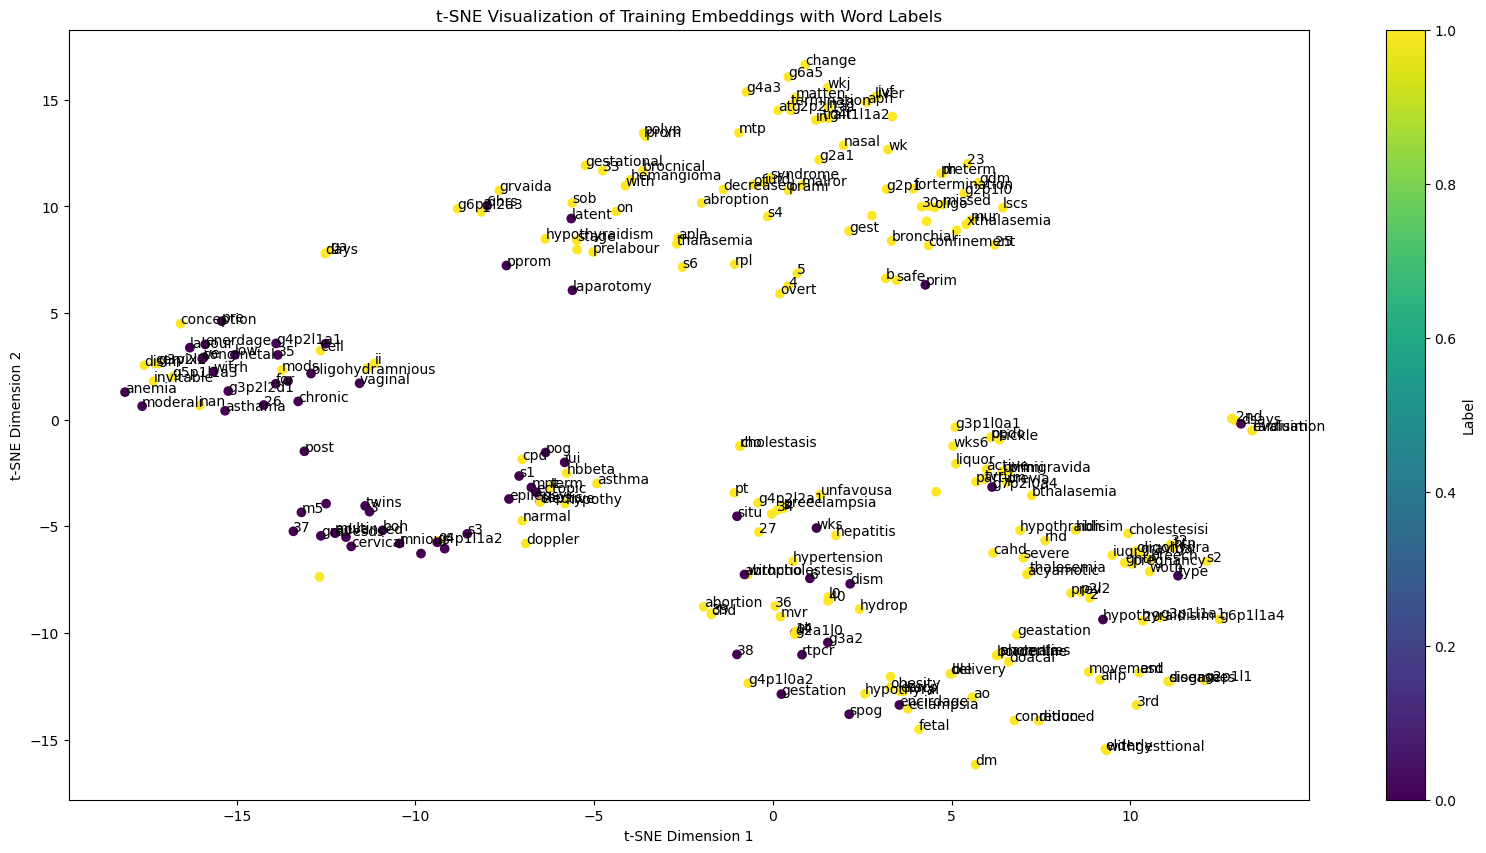

In [33]:
from sklearn.manifold import TSNE

# Assuming 'train_embeddings' contains the embeddings generated using BioBERT
# Assuming 'words' contains the corresponding array of words
# Tokenize the preprocessed text to get individual words
tokenized_words = [word for sentence in X_train['preprocessed_text'] for word in sentence.split()]

# Extract unique words to build the vocabulary
words = list(set(tokenized_words))

bert_model =  "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model)

# Generate BERT embeddings
print('generating embeddings')
train_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_train['preprocessed_text'], 10)])
    
    
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
train_embeddings_tsne = tsne.fit_transform(train_embeddings)

# Visualize the t-SNE embeddings with word labels
plt.figure(figsize=(20, 10))
plt.scatter(train_embeddings_tsne[:, 0], train_embeddings_tsne[:, 1], c=y_train, cmap='viridis')
for i, word in enumerate(words):
    plt.annotate(word, (train_embeddings_tsne[i, 0], train_embeddings_tsne[i, 1]))
plt.title('t-SNE Visualization of Training Embeddings with Word Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Label')
plt.show()

generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fcc2c2f2320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
Attr

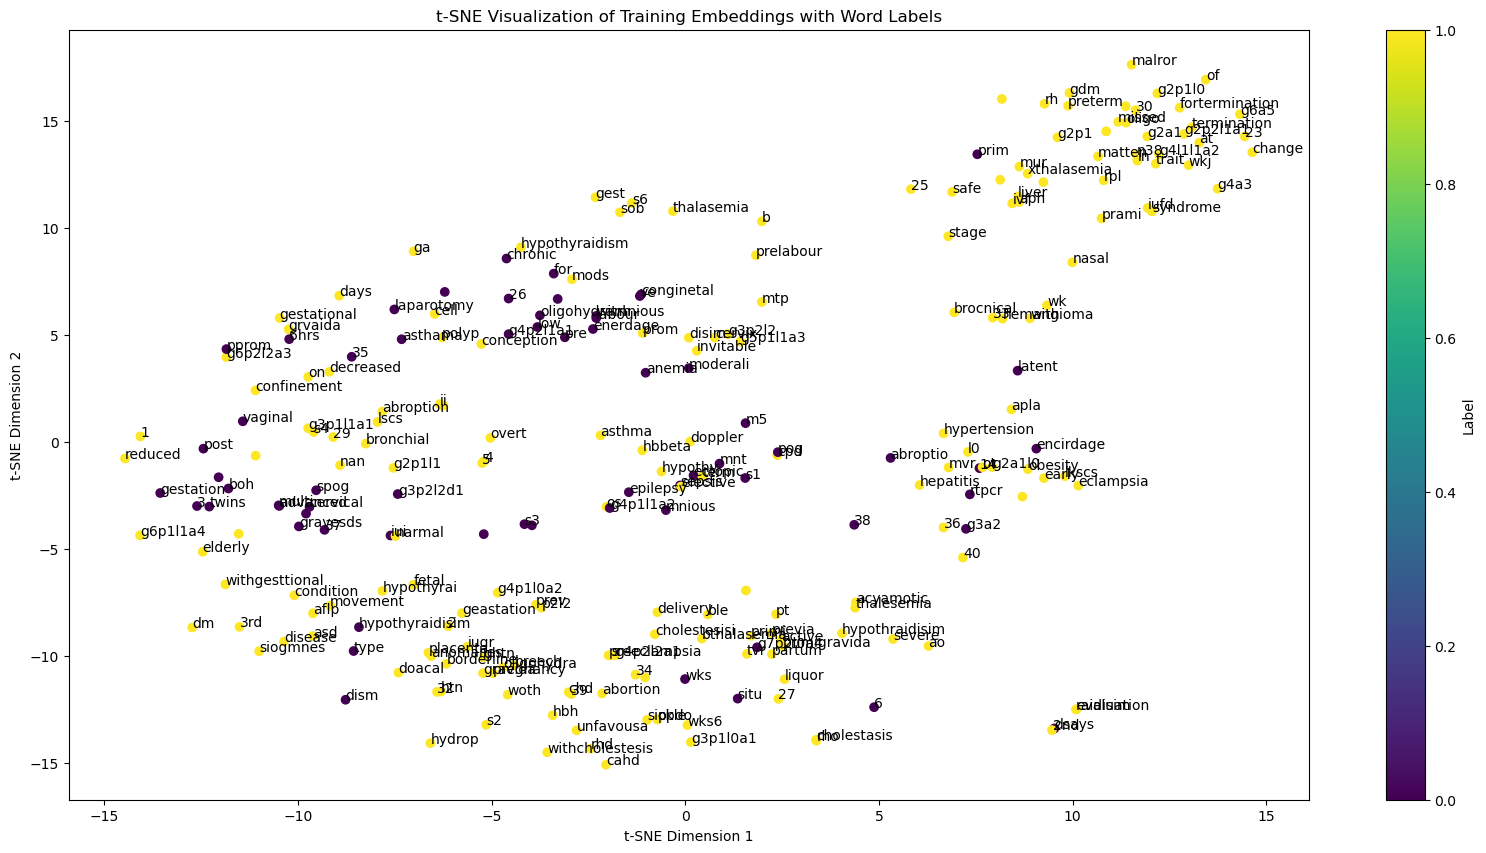

In [43]:
from sklearn.manifold import TSNE

# Assuming 'train_embeddings' contains the embeddings generated using BioBERT
# Assuming 'words' contains the corresponding array of words
# Tokenize the preprocessed text to get individual words
tokenized_words = [word for sentence in X_train['preprocessed_text'] for word in sentence.split()]

# Extract unique words to build the vocabulary
words = list(set(tokenized_words))

bert_model =  "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model)

# Generate BERT embeddings
print('generating embeddings')
train_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_train['preprocessed_text'], 10)])
    
    
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
train_embeddings_tsne = tsne.fit_transform(train_embeddings)

# Visualize the t-SNE embeddings with word labels
plt.figure(figsize=(20, 10))
plt.scatter(train_embeddings_tsne[:, 0], train_embeddings_tsne[:, 1], c=y_train, cmap='viridis')
for i, word in enumerate(words):
    plt.annotate(word, (train_embeddings_tsne[i, 0], train_embeddings_tsne[i, 1]))
plt.title('t-SNE Visualization of Training Embeddings with Word Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Label')
plt.show()

generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


generating pca components
generating train/test
running model
Fitting 3 folds for each of 10 candidates, totalling 30 fits


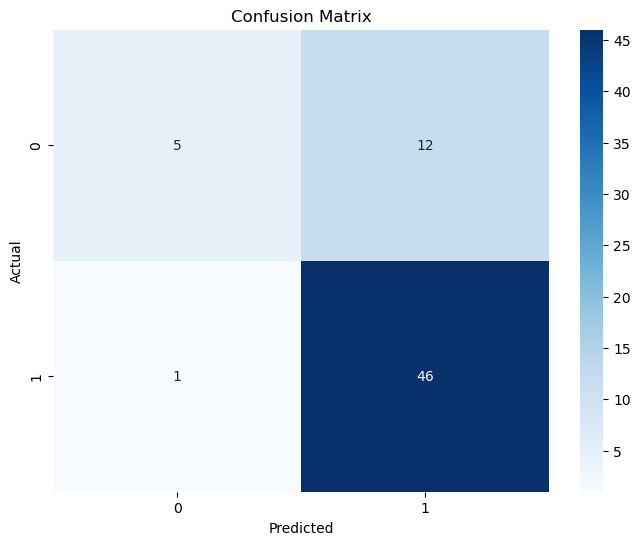

In [36]:
from sklearn.metrics import confusion_matrix # TOP 1
import seaborn as sns

# Assuming you have trained your model(s) and made predictions on the test set
bert_model = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model)

# Generate BERT embeddings
print('generating embeddings')
train_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_train['preprocessed_text'], 10)])
test_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_test['preprocessed_text'], 10)])

# Optional: Dimensionality reduction
print('generating pca components')
pca = PCA(n_components=0.75, svd_solver='full')
train_embeddings_reduced = pca.fit_transform(train_embeddings)
test_embeddings_reduced = pca.transform(test_embeddings)

print('generating train/test')
# Combine embeddings with numerical features for the "with BERT" model
train_combined_with_bert = np.hstack([train_embeddings_reduced, numerical_features.values])
test_combined_with_bert = np.hstack([test_embeddings_reduced, numerical_features_test.values])

print('running model')
# Train and evaluate models with BERT embeddings
best_model_with_bert = perform_random_search(train_combined_with_bert, y_train)
    
# Make predictions on the test set
y_pred_proba_with_bert = best_model_with_bert.predict_proba(test_combined_with_bert)[:, 1]

# Convert probabilities to binary predictions
y_pred_with_bert = np.where(y_pred_proba_with_bert > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_with_bert)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


generating embeddings


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


generating pca components
generating train/test
running model
Fitting 3 folds for each of 10 candidates, totalling 30 fits


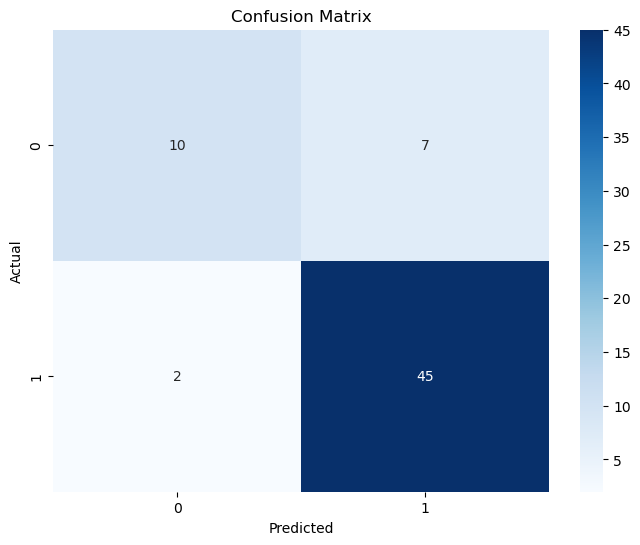

In [42]:
from sklearn.metrics import confusion_matrix # TOP2
import seaborn as sns

# Assuming you have trained your model(s) and made predictions on the test set
bert_model = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(bert_model)
model = AutoModel.from_pretrained(bert_model)

# Generate BERT embeddings
print('generating embeddings')
train_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_train['preprocessed_text'], 10)])
test_embeddings = np.vstack([create_bert_embeddings(model, tokenizer, batch.to_numpy().tolist()) for batch in np.array_split(X_test['preprocessed_text'], 10)])

# Optional: Dimensionality reduction
print('generating pca components')
pca = PCA(n_components=0.75, svd_solver='full')
train_embeddings_reduced = pca.fit_transform(train_embeddings)
test_embeddings_reduced = pca.transform(test_embeddings)

print('generating train/test')
# Combine embeddings with numerical features for the "with BERT" model
train_combined_with_bert = np.hstack([train_embeddings_reduced, numerical_features.values])
test_combined_with_bert = np.hstack([test_embeddings_reduced, numerical_features_test.values])

print('running model')
# Train and evaluate models with BERT embeddings
best_model_with_bert = perform_random_search(train_combined_with_bert, y_train)
    
# Make predictions on the test set
y_pred_proba_with_bert = best_model_with_bert.predict_proba(test_combined_with_bert)[:, 1]

# Convert probabilities to binary predictions
y_pred_with_bert = np.where(y_pred_proba_with_bert > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_with_bert)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [39]:
X_test.columns

Index(['patient_id', 'age', 'hb', 'ga_weeks', 'prvs_lscs', 'meconium', 'iugr',
       'gdm', 'hyperthyraidisim', 'kg_upd', 'height_upd', 'bmi', 'FUNDAL',
       'FUNDO-ANTERIOR', 'POSTERIOR', 'ANTERIOR', 'LEFT', 'RIGHT', 'primi',
       'abortion', 'dead_children', 'living_children', 'parity', 'gravida',
       'upd_col_OLIGOHYDRAMNIOUS', 'upd_col_FETAL DISTRESS', 'upd_col_BREECH',
       'upd_col_CEPHALIC', 'upd_col_PREVIA', 'upd_col_ECLAMPSIA',
       'upd_col_PPROM', 'upd_col_PROM', 'upd_col_PREECLAMPSIA',
       'upd_col_OBSTRICAL', 'upd_cervix_length', 'upd_afi', 'efw_upd',
       'fetus_type_THREE', 'fetus_type_TWIN', 'preprocessed_text'],
      dtype='object')

In [41]:
X_test.fetus_type_THREE.value_counts()

fetus_type_THREE
0    64
Name: count, dtype: int64